In [1]:
import numpy as np
import torch
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
eFC_dict = torch.load('../data/PPMI_efc.pth')
print(eFC_dict.keys())

dict_keys(['eFC', 'intra_left', 'intra_right', 'inter', 'homo', 'label'])


In [3]:
eFC = eFC_dict['eFC'].cpu()
intra_left = eFC_dict['intra_left'].cpu()
intra_right = eFC_dict['intra_right'].cpu()
inter = eFC_dict['inter'].cpu()
homo = eFC_dict['homo'].cpu()
labels = eFC_dict['label'].cpu()

print(f'eFC Shape: {eFC.shape}')
print(f'intra_left Shape: {intra_left.shape}')
print(f'intra_right Shape: {intra_right.shape}')
print(f'inter Shape: {inter.shape}')
print(f'homo Shape: {homo.shape}')
print(f'labels Shape: {labels.shape}')

eFC Shape: torch.Size([209, 6670, 6670])
intra_left Shape: torch.Size([209, 1653, 1653])
intra_right Shape: torch.Size([209, 1653, 1653])
inter Shape: torch.Size([209, 3364, 3364])
homo Shape: torch.Size([209, 1653, 1653])
labels Shape: torch.Size([209])


In [4]:
labels = labels.numpy()
labels[labels==2] = 1
labels[labels==3] = 1

In [5]:
eFC_CN = eFC[labels==0]
eFC_PD = eFC[labels==1]

del eFC
gc.collect()

intra_left_CN = intra_left[labels==0]
intra_left_PD = intra_left[labels==1]

del intra_left
gc.collect()

intra_right_CN = intra_right[labels==0]
intra_right_PD = intra_right[labels==1]

del intra_right
gc.collect()

inter_CN = inter[labels==0]
inter_PD = inter[labels==1]

del inter
gc.collect()

homo_CN = homo[labels==0]
homo_PD = homo[labels==1]

del homo
gc.collect()

0

In [6]:
# Function to perform two-sample t-test and return p-values and t-statistics
def perform_ttest(data_CN, data_PD):
    # Flatten the matrices to perform element-wise t-test
    data_CN_flattened = data_CN.reshape(data_CN.shape[0], -1)
    data_PD_flattened = data_PD.reshape(data_PD.shape[0], -1)
    
    t_stat, p_values = ttest_ind(data_CN_flattened, data_PD_flattened, axis=0)
    
    return t_stat, p_values

In [7]:
# Perform t-test for each type of eFC matrix
t_stat_eFC, p_values_eFC = perform_ttest(eFC_CN, eFC_PD)
t_stat_intra_left, p_values_intra_left = perform_ttest(intra_left_CN, intra_left_PD)
t_stat_intra_right, p_values_intra_right = perform_ttest(intra_right_CN, intra_right_PD)
t_stat_inter, p_values_inter = perform_ttest(inter_CN, inter_PD)
t_stat_homo, p_values_homo = perform_ttest(homo_CN, homo_PD)

/home/m_abdelmege/miniconda3/envs/brain_connectome/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [8]:
threshold = 0.05

# Function to count p-values below a given threshold and calculate the ratio
def count_and_ratio_pvalues_below_threshold(p_values, threshold):
    count_below_threshold = np.sum(p_values < threshold)
    total_count = p_values.size
    ratio_below_threshold = count_below_threshold / total_count
    return count_below_threshold, ratio_below_threshold

# Count the number of p-values below the threshold and calculate the ratio
count_eFC, ratio_eFC = count_and_ratio_pvalues_below_threshold(p_values_eFC, threshold)
count_intra_left, ratio_intra_left = count_and_ratio_pvalues_below_threshold(p_values_intra_left, threshold)
count_intra_right, ratio_intra_right = count_and_ratio_pvalues_below_threshold(p_values_intra_right, threshold)
count_inter, ratio_inter = count_and_ratio_pvalues_below_threshold(p_values_inter, threshold)
count_homo, ratio_homo = count_and_ratio_pvalues_below_threshold(p_values_homo, threshold)

# Output the results
print(f"Number of p-values below {threshold} for eFC: {count_eFC}, Ratio: {ratio_eFC}")
print(f"Number of p-values below {threshold} for intra-left eFC: {count_intra_left}, Ratio: {ratio_intra_left}")
print(f"Number of p-values below {threshold} for intra-right eFC: {count_intra_right}, Ratio: {ratio_intra_right}")
print(f"Number of p-values below {threshold} for interhemispheric eFC: {count_inter}, Ratio: {ratio_inter}")
print(f"Number of p-values below {threshold} for homotopic eFC: {count_homo}, Ratio: {ratio_homo}")

Number of p-values below 0.05 for eFC: 1056443, Ratio: 0.023746215348098065
Number of p-values below 0.05 for intra-left eFC: 62352, Ratio: 0.022819424178444736
Number of p-values below 0.05 for intra-right eFC: 76564, Ratio: 0.028020695291224702
Number of p-values below 0.05 for interhemispheric eFC: 270143, Ratio: 0.02387161184875601
Number of p-values below 0.05 for homotopic eFC: 21492, Ratio: 0.007865586740491632


In [9]:
from sklearn.cluster import KMeans
from scipy.stats import entropy
from tqdm import tqdm

def detect_communities(eFC, n_clusters=5):
    """
    Perform community detection using clustering on the eFC matrix.
    Args:
    - eFC: Numpy array or Tensor of shape (E, E), where E is the number of edges.
    - n_clusters: Number of clusters for KMeans.
    
    Returns:
    - clusters: Numpy array of shape (E,) representing the cluster assignments for each edge.
    """
    clustering_model = KMeans(n_clusters=n_clusters, n_init=10)
    clusters = clustering_model.fit_predict(eFC)
    return clusters

def map_edges_to_nodes(clusters, N):
    """
    Map detected communities to nodes.
    Args:
    - clusters: Numpy array of shape (E,) representing the cluster assignments for each edge.
    - N: Number of nodes/regions in the original time series data.
    
    Returns:
    - node_communities: Numpy array of shape (N, N) representing the community membership of each node.
    """
    node_communities = np.zeros((N, N))
    triu_indices = np.triu_indices(N, k=1)
    for idx, cluster in enumerate(clusters):
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        node_communities[i, j] = cluster + 1  # +1 to avoid zero indexing issues
        node_communities[j, i] = cluster + 1
    return node_communities

def calculate_entropy(node_communities):
    """
    Calculate the entropy of each node's community participation.
    Args:
    - node_communities: Numpy array of shape (N, N) representing the community membership of each node.
    
    Returns:
    - entropies: Numpy array of shape (N,) representing the entropy of each node.
    """
    entropies = np.apply_along_axis(entropy, 1, node_communities)
    return entropies

def pipeline(eFC_matrices, n_clusters=5, N=116):
    """
    Wrapper pipeline function to process a set of eFCs and perform community-based analysis.
    Args:
    - eFC_matrices: Numpy array of shape (M, E, E), where M is the number of records, E is the number of edges.
    - n_clusters: Number of clusters for KMeans.
    
    Returns:
    - results: Dictionary containing the community assignments, node community matrices, and entropies.
    """
    M, E, _ = eFC_matrices.shape
    
    cluster_assignments = []
    node_communities = []
    entropies = []

    for i in tqdm(range(M), desc="Processing eFC matrices"):
        clusters = detect_communities(eFC_matrices[i], n_clusters)
        node_comm = map_edges_to_nodes(clusters, N)
        entropy_values = calculate_entropy(node_comm)
        
        cluster_assignments.append(clusters)
        node_communities.append(node_comm)
        entropies.append(entropy_values)
    
    results = {
        "cluster_assignments": np.array(cluster_assignments),
        "node_communities": np.array(node_communities),
        "entropies": np.array(entropies)
    }
    
    return results

Processing eFC matrices: 100%|████████████████| 194/194 [06:36<00:00,  2.05s/it]

T-statistic: -3.4260440623313686, P-value: 0.0006134563260310757


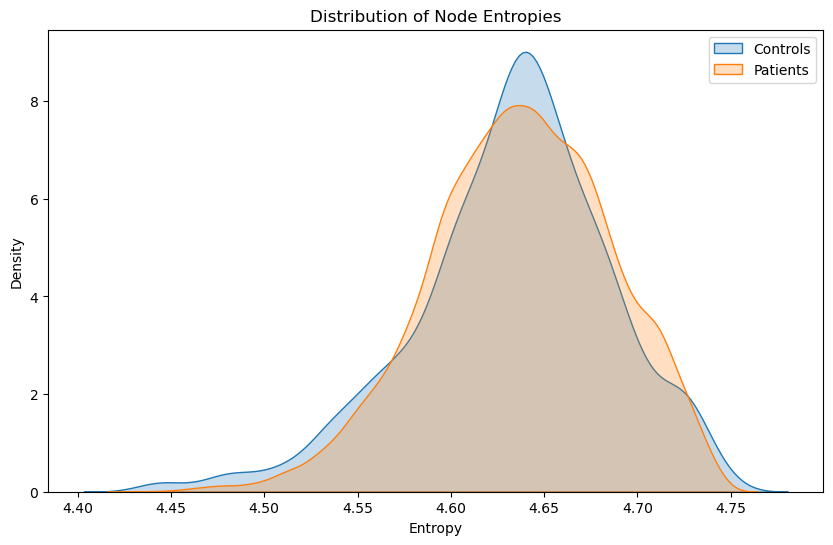

In [10]:
# Calculate entropies for both groups
results_CN = pipeline(eFC_CN)
results_PD = pipeline(eFC_PD)

entropies_CN = results_CN['entropies']
entropies_PD = results_PD['entropies']

# Perform t-test on the entropies
t_stat, p_value = ttest_ind(entropies_CN.flatten(), entropies_PD.flatten())

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting the distributions of entropies for visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN.flatten(), label='Controls', shade=True)
sns.kdeplot(entropies_PD.flatten(), label='Patients', shade=True)
plt.title('Distribution of Node Entropies')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: [-2.28069595 -0.9052159  -1.83436793 -1.15774512 -1.87812406 -1.76203725
 -0.96681707 -0.56297403 -2.34561839 -0.38669302  0.03801737 -0.68131323
  0.19971494 -0.57464814 -0.44134667 -0.05136221 -0.08032793 -1.30886129
 -2.8066974  -2.23260024 -0.27256787 -1.03743123 -2.27958876 -1.16912221
  0.46973954  0.23526995 -1.57436475 -1.11402812  0.1115002   0.44934336
 -0.82373385 -1.80313682 -0.42317285 -1.53346125 -1.11344526  0.22395377
  0.83797566  1.10864167 -0.5670597   0.01442648 -0.00502047  1.41078099
 -0.04691087  0.23923427  0.41111798  0.97828159  0.48880854  0.70968032
  0.79988593  1.56704503  1.46663174  0.12272133  2.17042656  0.95120235
 -0.08836784  0.70543976  0.12765192  0.10391881 -0.43150598 -1.27517953
  0.33508005 -1.19078186 -0.74454274 -1.01771962 -1.85647406 -1.69749581
 -1.54315939 -2.15604094 -2.51466954 -1.9340263  -2.08688869 -1.22980268
 -1.00965849 -0.03693551 -0.65909115 -0.31478636  0.66340526 -0.3045666
 -0.26853897  1.30530538  0.3177746   1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


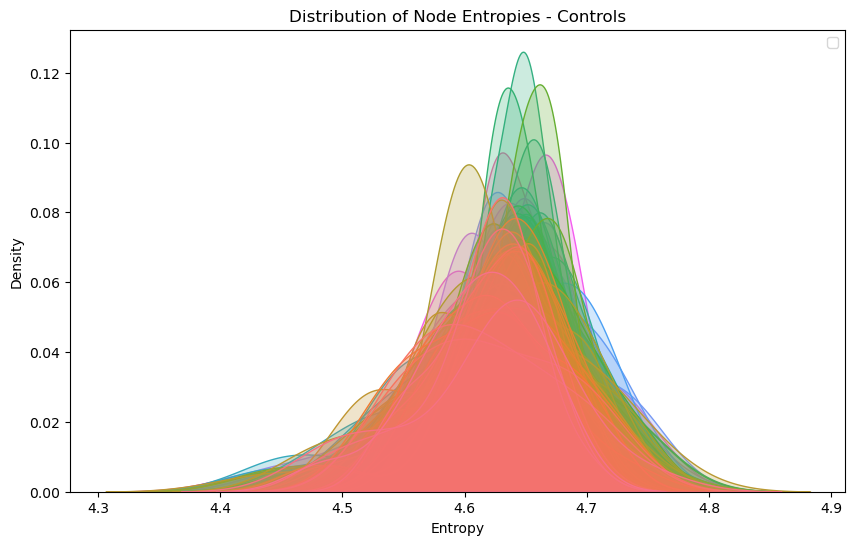

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


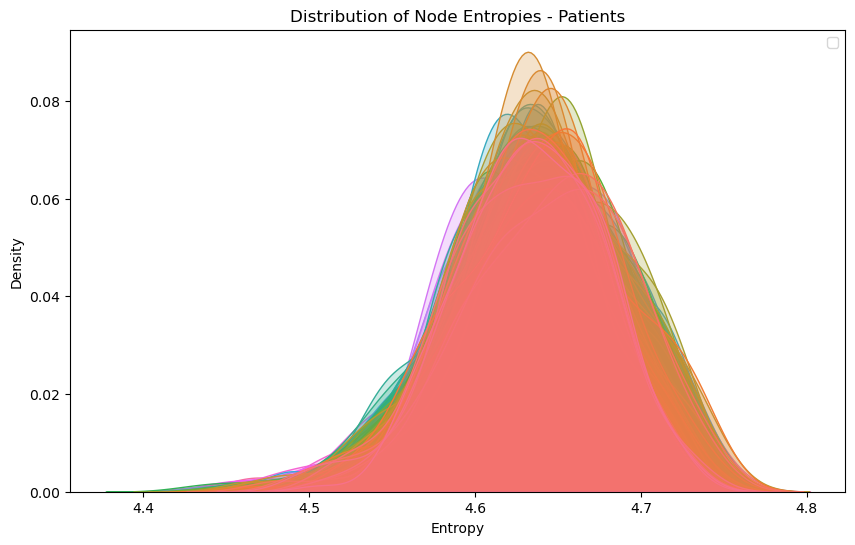

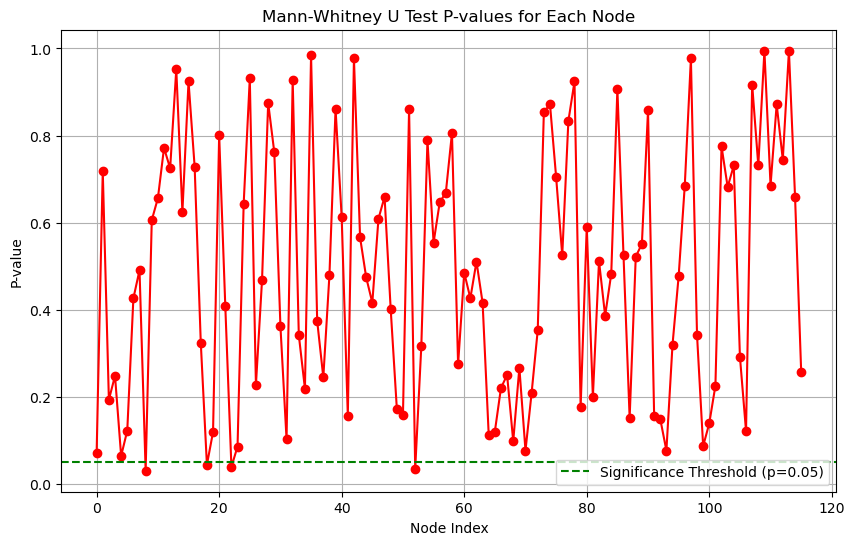

In [11]:
from scipy.stats import mannwhitneyu

# Perform t-test
t_stat, p_value = ttest_ind(entropies_CN, entropies_PD)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(entropies_CN, entropies_PD)
print(f"Mann-Whitney U Test: Stat = {stat}, P-value = {p_value}")

# Calculate effect size
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)

effect_size = cohen_d(entropies_CN, entropies_PD)
print(f"Cohen's d: {effect_size}")

# Plotting the distribution for Controls
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN, shade=True)
plt.title('Distribution of Node Entropies - Controls')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plotting the distribution for Patients
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_PD, shade=True)
plt.title('Distribution of Node Entropies - Patients')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()


# Plotting Mann-Whitney U p-values
plt.figure(figsize=(10, 6))
plt.plot(range(len(p_value)), p_value, marker='o', linestyle='-', color='r')
plt.axhline(y=0.05, color='g', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('Mann-Whitney U Test P-values for Each Node')
plt.xlabel('Node Index')
plt.ylabel('P-value')
plt.grid(True)
plt.legend()
plt.show()

Processing eFC matrices: 100%|████████████████| 194/194 [00:48<00:00,  4.02it/s]


T-statistic: 1.923226371382598, P-value: 0.05447502703325515


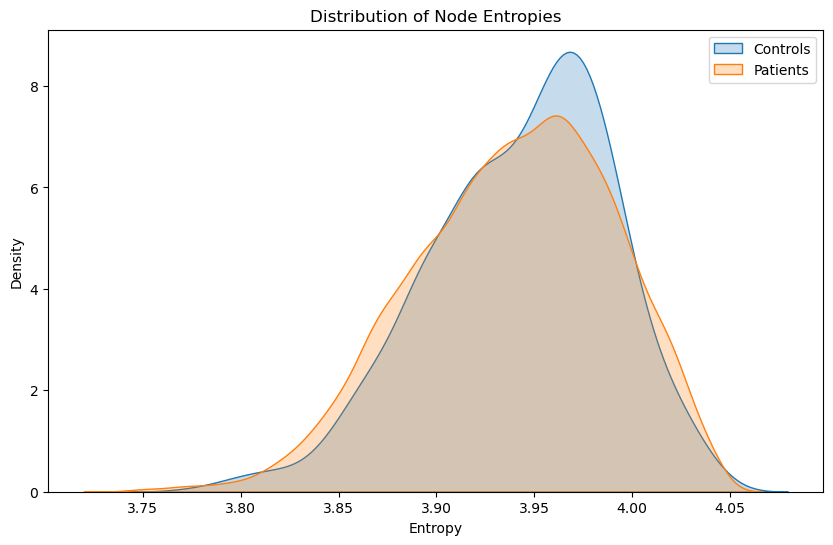

In [12]:
# Calculate entropies for both groups
results_CN = pipeline(homo_CN, N=58)
results_PD = pipeline(homo_PD, N=58)

entropies_CN = results_CN['entropies']
entropies_PD = results_PD['entropies']

# Perform t-test on the entropies
t_stat, p_value = ttest_ind(entropies_CN.flatten(), entropies_PD.flatten())

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting the distributions of entropies for visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN.flatten(), label='Controls', shade=True)
sns.kdeplot(entropies_PD.flatten(), label='Patients', shade=True)
plt.title('Distribution of Node Entropies')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: [ 0.04089377  0.57743349 -0.02136806 -0.02616848  0.74513736 -0.01922675
  0.38261776  1.71130399 -0.82192117 -0.18715815  0.05018795 -0.26161811
 -0.22133408  0.51348185  1.2809342   0.23948852 -1.05951961  0.61434181
  0.34290234  0.53159587  0.93891631 -0.10372563 -0.93003646  0.60990951
 -0.99647454  0.03287847  1.37889288  0.58503894  2.51418554 -0.42919128
  0.94762957  2.29407981  0.90272119 -0.28442984  0.25801975  0.53181786
 -0.03976581 -0.03554975  1.17958322  0.13830611  1.58355214  0.50228635
  1.15809106  0.35369326 -0.72293105 -0.93824413 -1.21920152  0.95605264
  1.83314787 -0.84172864 -0.80027728 -0.89682867  0.01293464 -0.36660424
 -0.73863596  0.99056673 -0.40808299  0.79747079], P-value: [0.96742    0.56427418 0.98297264 0.97914817 0.45703388 0.98467874
 0.70239577 0.08852291 0.41206746 0.85171995 0.96002101 0.79387601
 0.82505049 0.60816193 0.20165002 0.81096377 0.29059794 0.53966411
 0.7320199  0.59557594 0.34886799 0.91748751 0.35343553 0.54259069
 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


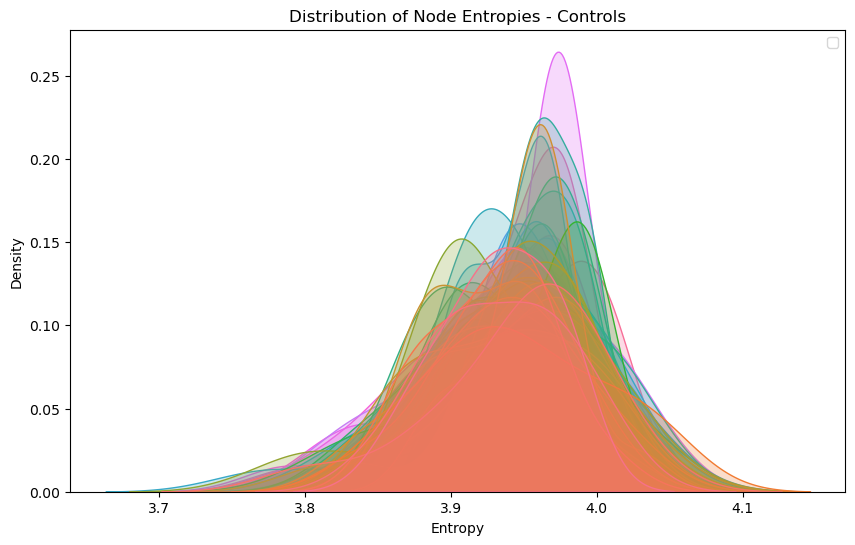

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


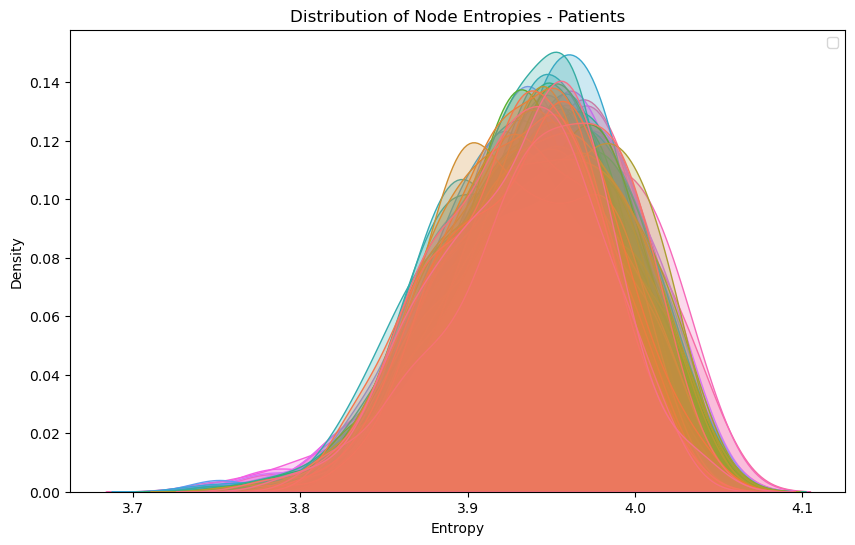

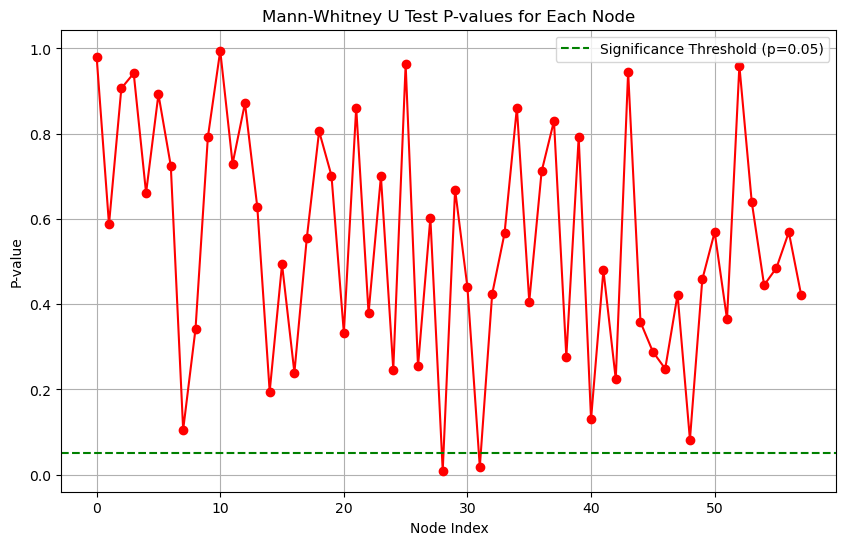

In [13]:
# Perform t-test
t_stat, p_value = ttest_ind(entropies_CN, entropies_PD)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(entropies_CN, entropies_PD)
print(f"Mann-Whitney U Test: Stat = {stat}, P-value = {p_value}")


effect_size = cohen_d(entropies_CN, entropies_PD)
print(f"Cohen's d: {effect_size}")

# Plotting the distribution for Controls
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN, shade=True)
plt.title('Distribution of Node Entropies - Controls')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plotting the distribution for Patients
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_PD, shade=True)
plt.title('Distribution of Node Entropies - Patients')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()


# Plotting Mann-Whitney U p-values
plt.figure(figsize=(10, 6))
plt.plot(range(len(p_value)), p_value, marker='o', linestyle='-', color='r')
plt.axhline(y=0.05, color='g', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('Mann-Whitney U Test P-values for Each Node')
plt.xlabel('Node Index')
plt.ylabel('P-value')
plt.grid(True)
plt.legend()
plt.show()

Processing eFC matrices: 100%|████████████████| 194/194 [02:00<00:00,  1.61it/s]

T-statistic: 0.22202828915562473, P-value: 0.8242937316292529


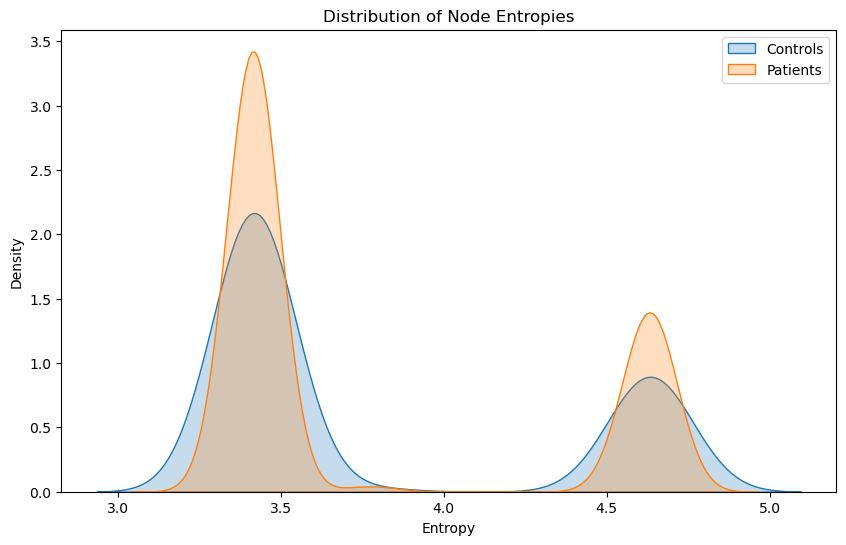

In [14]:
# Calculate entropies for both groups
results_CN = pipeline(inter_CN)
results_PD = pipeline(inter_PD)

entropies_CN = results_CN['entropies']
entropies_PD = results_PD['entropies']

# Perform t-test on the entropies
t_stat, p_value = ttest_ind(entropies_CN.flatten(), entropies_PD.flatten())

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting the distributions of entropies for visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN.flatten(), label='Controls', shade=True)
sns.kdeplot(entropies_PD.flatten(), label='Patients', shade=True)
plt.title('Distribution of Node Entropies')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: [ 0.5906259  -0.06356044 -0.04452404  0.26210072  0.87356771  0.79155858
  0.75961884  0.47860395  0.6560552  -0.37474324 -0.47213873  0.16011322
  0.51337652  0.09188143  0.0823174  -0.46755732  0.36643414  0.45923206
  0.55429398 -0.43229539  0.48881533  0.3759538   0.4740419  -0.31431397
  0.52720858 -0.63155918 -0.64205316 -0.51448561 -0.18158344  1.39267046
  0.72075823  0.08708868  0.48457132  0.90361622  0.25250296  0.2167312
  1.37180293  1.20996036  0.49814404  0.62861068  0.09195752 -0.53264264
  0.17062109  0.45642132  0.31935896 -0.24987196 -0.38677584 -1.12432299
  0.33560411  0.39221583  1.05864341  0.3504899   1.02789151  0.87803157
  1.28639722  0.68139724  0.43881186  0.80567844  2.5405515   1.40463903
  1.98138492  0.70831193  1.2734877   0.91181377  0.62764052  0.01978291
  0.74084732  1.74467173  0.18314707 -0.12866206  1.23473961  1.20179991
  0.63612661 -0.47802471  0.06443153 -0.73716746 -0.41748969 -0.37947026
 -0.16733991 -0.01101441 -0.55402979 -0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


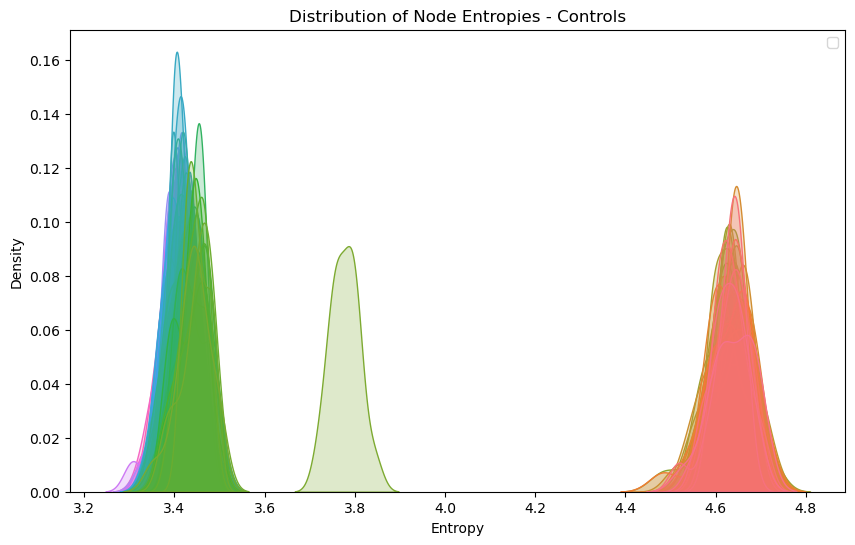

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


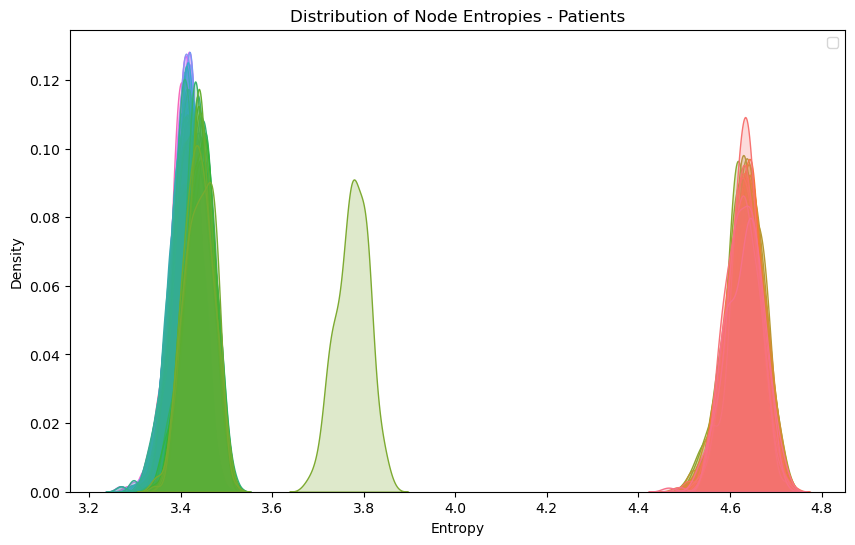

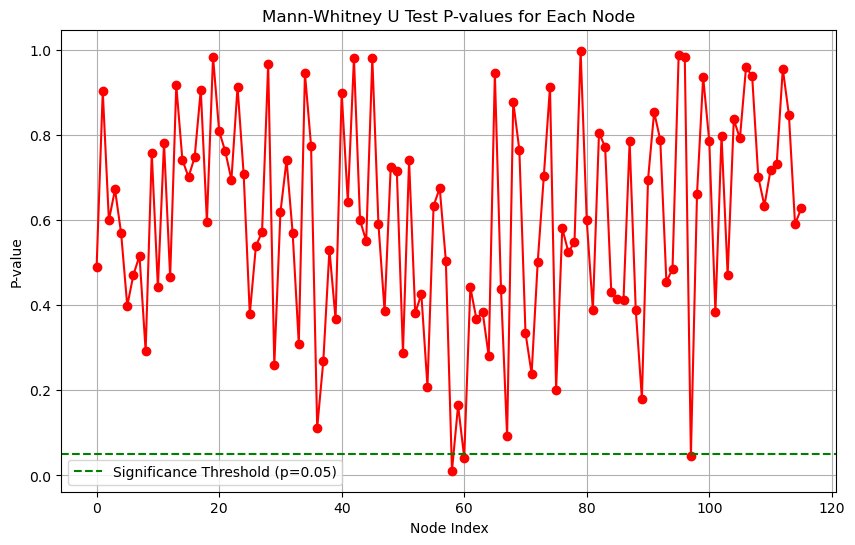

In [15]:
# Perform t-test
t_stat, p_value = ttest_ind(entropies_CN, entropies_PD)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(entropies_CN, entropies_PD)
print(f"Mann-Whitney U Test: Stat = {stat}, P-value = {p_value}")


effect_size = cohen_d(entropies_CN, entropies_PD)
print(f"Cohen's d: {effect_size}")

# Plotting the distribution for Controls
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN, shade=True)
plt.title('Distribution of Node Entropies - Controls')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plotting the distribution for Patients
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_PD, shade=True)
plt.title('Distribution of Node Entropies - Patients')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()


# Plotting Mann-Whitney U p-values
plt.figure(figsize=(10, 6))
plt.plot(range(len(p_value)), p_value, marker='o', linestyle='-', color='r')
plt.axhline(y=0.05, color='g', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('Mann-Whitney U Test P-values for Each Node')
plt.xlabel('Node Index')
plt.ylabel('P-value')
plt.grid(True)
plt.legend()
plt.show()

Processing eFC matrices: 100%|████████████████| 194/194 [00:47<00:00,  4.11it/s]

T-statistic: -0.35455289687065056, P-value: 0.7229276532303484


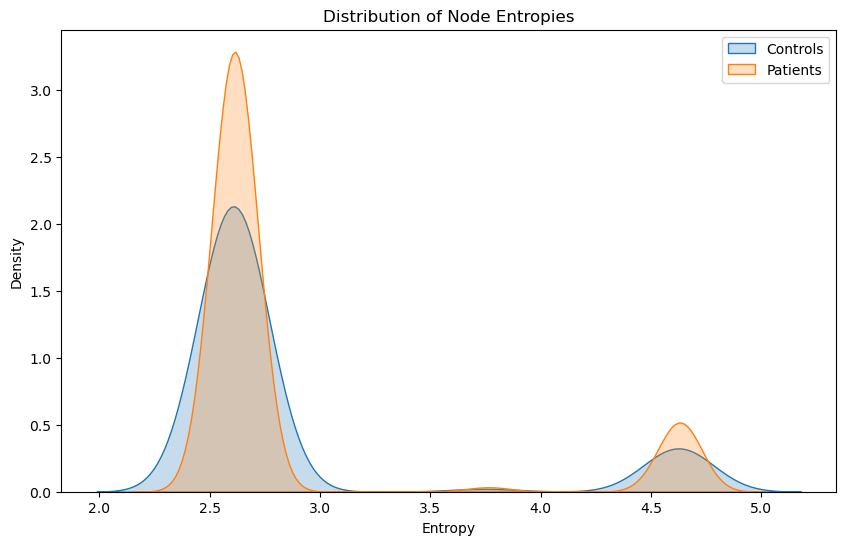

In [16]:
# Calculate entropies for both groups
results_CN = pipeline(intra_left_CN)
results_PD = pipeline(intra_left_PD)

entropies_CN = results_CN['entropies']
entropies_PD = results_PD['entropies']

# Perform t-test on the entropies
t_stat, p_value = ttest_ind(entropies_CN.flatten(), entropies_PD.flatten())

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting the distributions of entropies for visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN.flatten(), label='Controls', shade=True)
sns.kdeplot(entropies_PD.flatten(), label='Patients', shade=True)
plt.title('Distribution of Node Entropies')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: [-1.15763227e+00 -3.88509052e-01 -1.93641286e+00 -2.26062225e-01
  1.76551052e-02 -8.21340049e-01 -7.51344069e-01  1.11117178e-01
 -1.17871783e+00 -1.07791345e+00  8.29127295e-02 -1.34810686e+00
 -4.45255131e-01  1.30283158e+00 -1.58947022e-01 -1.23451438e+00
 -1.00853025e+00 -9.42526556e-01  1.95001858e-01 -4.46309830e-01
  6.98348576e-01 -8.48335703e-01  4.04855962e-01 -8.28140366e-01
 -2.54917482e+00 -1.12926109e+00  2.46372026e-01 -1.30578918e+00
 -1.29296962e+00 -1.53219245e+00 -1.51793708e+00 -1.93689076e+00
  2.64574945e-01 -1.32376554e+00 -1.65765956e+00 -1.44953675e+00
 -1.64874077e+00 -1.51836760e-01 -4.02762523e-01 -1.73537927e+00
 -1.77905564e+00 -9.47270795e-01 -6.61349008e-01 -7.54216768e-01
 -1.26091314e+00 -7.95597626e-01 -2.70075661e-01 -9.95994954e-01
  3.80696432e-01 -1.21370595e+00 -1.00033422e+00 -5.42057418e-01
 -2.57848635e+00 -1.60386177e+00 -5.54098082e-01  2.90739122e-01
 -2.70789901e-01  2.64544113e-01 -1.85287417e-01 -1.77341330e-01
 -1.46024914

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


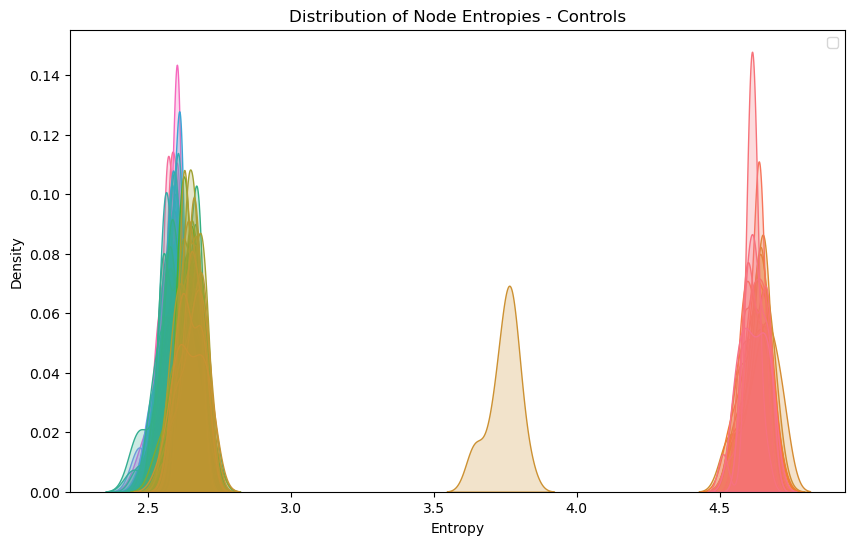

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


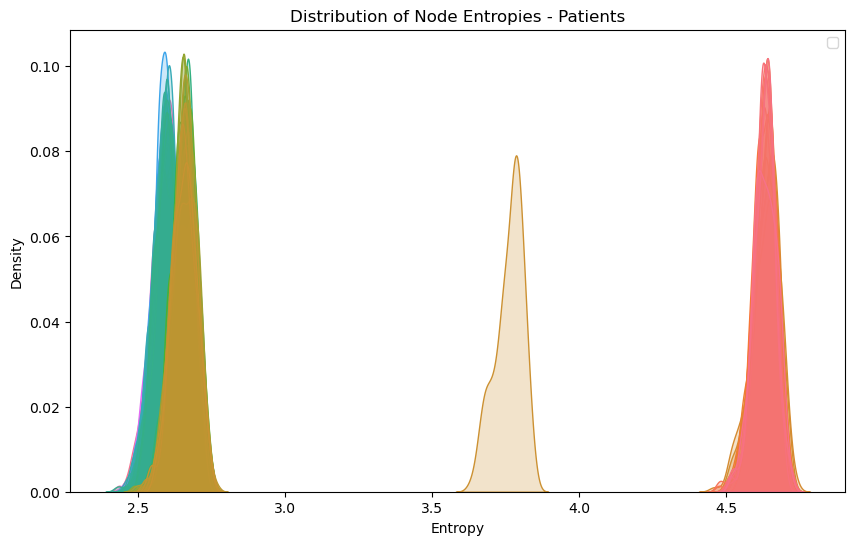

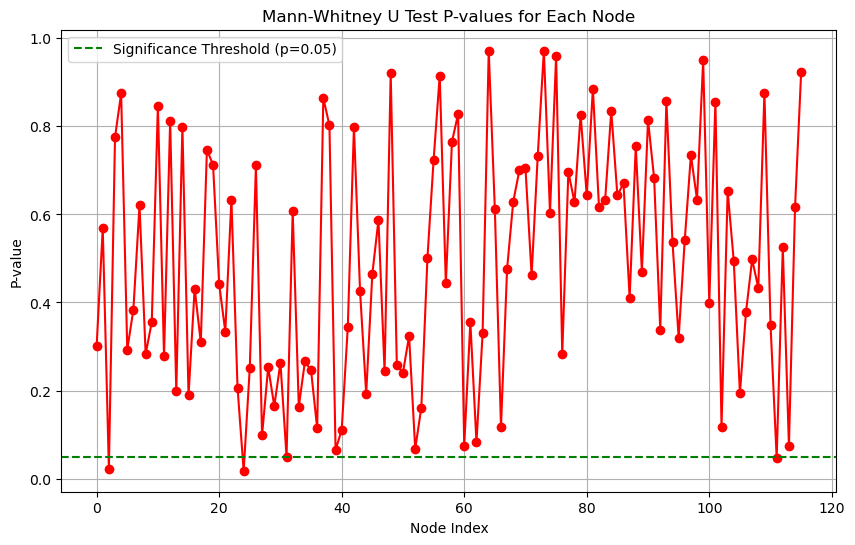

In [17]:
# Perform t-test
t_stat, p_value = ttest_ind(entropies_CN, entropies_PD)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(entropies_CN, entropies_PD)
print(f"Mann-Whitney U Test: Stat = {stat}, P-value = {p_value}")


effect_size = cohen_d(entropies_CN, entropies_PD)
print(f"Cohen's d: {effect_size}")

# Plotting the distribution for Controls
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN, shade=True)
plt.title('Distribution of Node Entropies - Controls')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plotting the distribution for Patients
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_PD, shade=True)
plt.title('Distribution of Node Entropies - Patients')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()


# Plotting Mann-Whitney U p-values
plt.figure(figsize=(10, 6))
plt.plot(range(len(p_value)), p_value, marker='o', linestyle='-', color='r')
plt.axhline(y=0.05, color='g', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('Mann-Whitney U Test P-values for Each Node')
plt.xlabel('Node Index')
plt.ylabel('P-value')
plt.grid(True)
plt.legend()
plt.show()

Processing eFC matrices: 100%|████████████████| 194/194 [00:45<00:00,  4.23it/s]

T-statistic: 0.18713197526705216, P-value: 0.8515587243621994


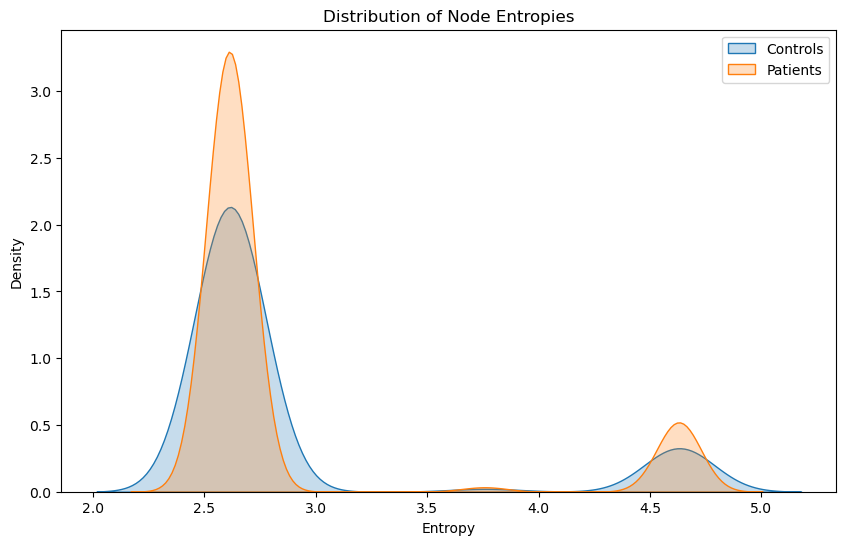

In [18]:
# Calculate entropies for both groups
results_CN = pipeline(intra_right_CN)
results_PD = pipeline(intra_right_PD)

entropies_CN = results_CN['entropies']
entropies_PD = results_PD['entropies']

# Perform t-test on the entropies
t_stat, p_value = ttest_ind(entropies_CN.flatten(), entropies_PD.flatten())

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting the distributions of entropies for visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN.flatten(), label='Controls', shade=True)
sns.kdeplot(entropies_PD.flatten(), label='Patients', shade=True)
plt.title('Distribution of Node Entropies')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: [-0.04470762 -0.00698725 -0.58101415 -0.60600993 -0.46139534  0.98156136
 -0.1684808   0.04061565  0.09219381  1.1541376   0.79937005  1.66047437
  1.21383572 -0.79018082 -0.13322401  0.45562997  1.53060974 -0.00336466
  1.44994362 -0.54093517  0.16880801 -0.79192642  0.93740621  0.82668184
 -0.26167993 -0.72823293 -0.35492493 -1.10716836  1.4522304   1.46130668
 -0.38242529  1.251852    0.4982746  -0.0587058   1.03688982  0.2331869
  1.01718687 -0.22322544  0.50424818  0.77276043  0.20246079 -0.32144358
  0.19530775  1.18200004 -0.59730098 -0.58324834  0.4441606   0.03044027
  0.42141399  0.36328344 -0.38396973  0.4530142   0.88010627  1.00763474
  1.44962802  2.56078982  2.14732785  1.37845575  1.50826677  0.86222929
  0.34932704  0.40739146  0.5385015  -0.6012784   0.26644022 -0.56273642
 -0.18651001  0.10417927 -0.07690014  0.67453537 -0.3342269   0.6539713
  0.69761259  0.44314223 -0.01618459  1.02695412 -0.0086935   1.15225263
 -0.40627995  0.50177426 -1.87173112  0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


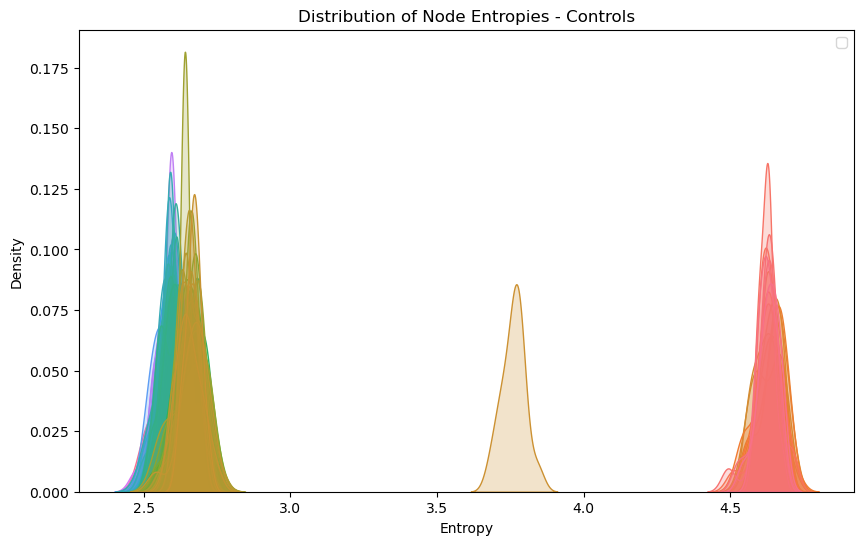

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


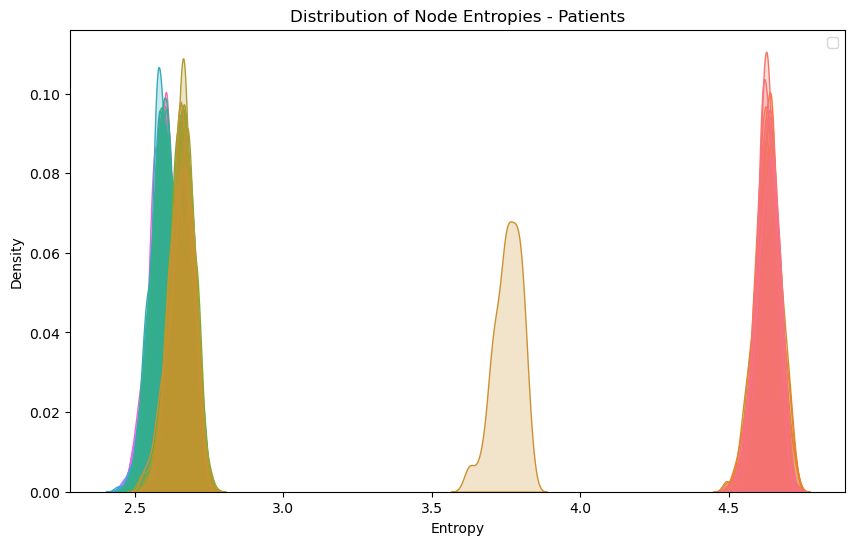

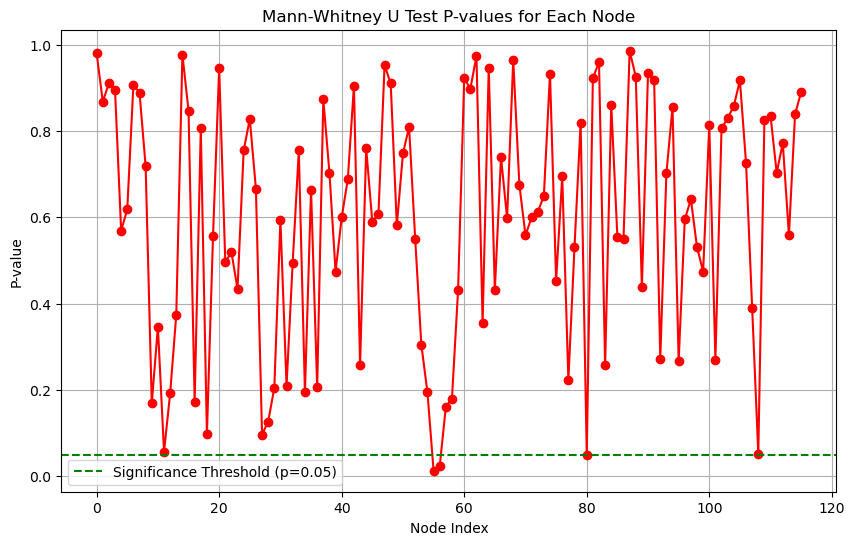

In [19]:
# Perform t-test
t_stat, p_value = ttest_ind(entropies_CN, entropies_PD)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(entropies_CN, entropies_PD)
print(f"Mann-Whitney U Test: Stat = {stat}, P-value = {p_value}")

effect_size = cohen_d(entropies_CN, entropies_PD)
print(f"Cohen's d: {effect_size}")

# Plotting the distribution for Controls
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_CN, shade=True)
plt.title('Distribution of Node Entropies - Controls')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plotting the distribution for Patients
plt.figure(figsize=(10, 6))
sns.kdeplot(entropies_PD, shade=True)
plt.title('Distribution of Node Entropies - Patients')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend()
plt.show()


# Plotting Mann-Whitney U p-values
plt.figure(figsize=(10, 6))
plt.plot(range(len(p_value)), p_value, marker='o', linestyle='-', color='r')
plt.axhline(y=0.05, color='g', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('Mann-Whitney U Test P-values for Each Node')
plt.xlabel('Node Index')
plt.ylabel('P-value')
plt.grid(True)
plt.legend()
plt.show()